<a href="https://colab.research.google.com/github/brunacustoodio/Analise-de-Vendas/blob/main/An%C3%A1lise_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A base de dados utilizada para análise de dados foi "theLook eCommerce" é uma coleção de conjuntos de dados que reúne informações históricas de um eCommerce, abrangendo diversas categorias como produtos, vendas, clientes, entre outros. Essa base de dados é projetada para oferecer uma visão abrangente do funcionamento do eCommerce, permitindo análises e insights valiosos sobre o comportamento dos clientes, desempenho de produtos e tendências de vendas ao longo do tempo.






In [ ]:
!pip install google-cloud-bigquery

Bibliotecas necessárias

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt


Autenticação no BigQuery usando as credenciais de serviço fornecidas no arquivo JSON e especificando o ID do projeto.



In [ ]:
credentials = service_account.Credentials.from_service_account_file('/content/my-project-82471-1698102235390-192fda3bc34f.json')
project_id = 'my-project-82471-1698102235390'
client = bigquery.Client(credentials= credentials,project=project_id)

Realiza uma consulta para obter os 10 primeiros registros da tabela products no conjunto de dados

In [ ]:
query = client.query(
    """
    SELECT * FROM
    `bigquery-public-data.thelook_ecommerce.products`
    LIMIT 10
    """)
results = query.result()
for row in results:
	print(row)

Row((13842, 2.518749990849756, 'Accessories', 'Low Profile Dyed Cotton Twill Cap - Navy W39S55D', 'MG', 6.25, 'Women', 'EBD58B8A3F1D72F4206201DA62FB1204', 1), {'id': 0, 'cost': 1, 'category': 2, 'name': 3, 'brand': 4, 'retail_price': 5, 'department': 6, 'sku': 7, 'distribution_center_id': 8})
Row((13928, 2.3383499148894105, 'Accessories', 'Low Profile Dyed Cotton Twill Cap - Putty W39S55D', 'MG', 5.949999809265137, 'Women', '2EAC42424D12436BDD6A5B8A88480CC3', 1), {'id': 0, 'cost': 1, 'category': 2, 'name': 3, 'brand': 4, 'retail_price': 5, 'department': 6, 'sku': 7, 'distribution_center_id': 8})
Row((14115, 4.879559879379869, 'Accessories', 'Enzyme Regular Solid Army Caps-Black W35S45D', 'MG', 10.989999771118164, 'Women', 'EE364229B2791D1EF9355708EFF0BA34', 1), {'id': 0, 'cost': 1, 'category': 2, 'name': 3, 'brand': 4, 'retail_price': 5, 'department': 6, 'sku': 7, 'distribution_center_id': 8})
Row((14157, 4.648769887297898, 'Accessories', 'Enzyme Regular Solid Army Caps-Olive W35S45D (

A consulta extrai o ano e mês da data de criação de pedidos (created_at) e calcula o total de vendas (SUM(oi.sale_price)) para cada mês. A consulta resulta em um conjunto de dados que é armazenado na variável sales_query.

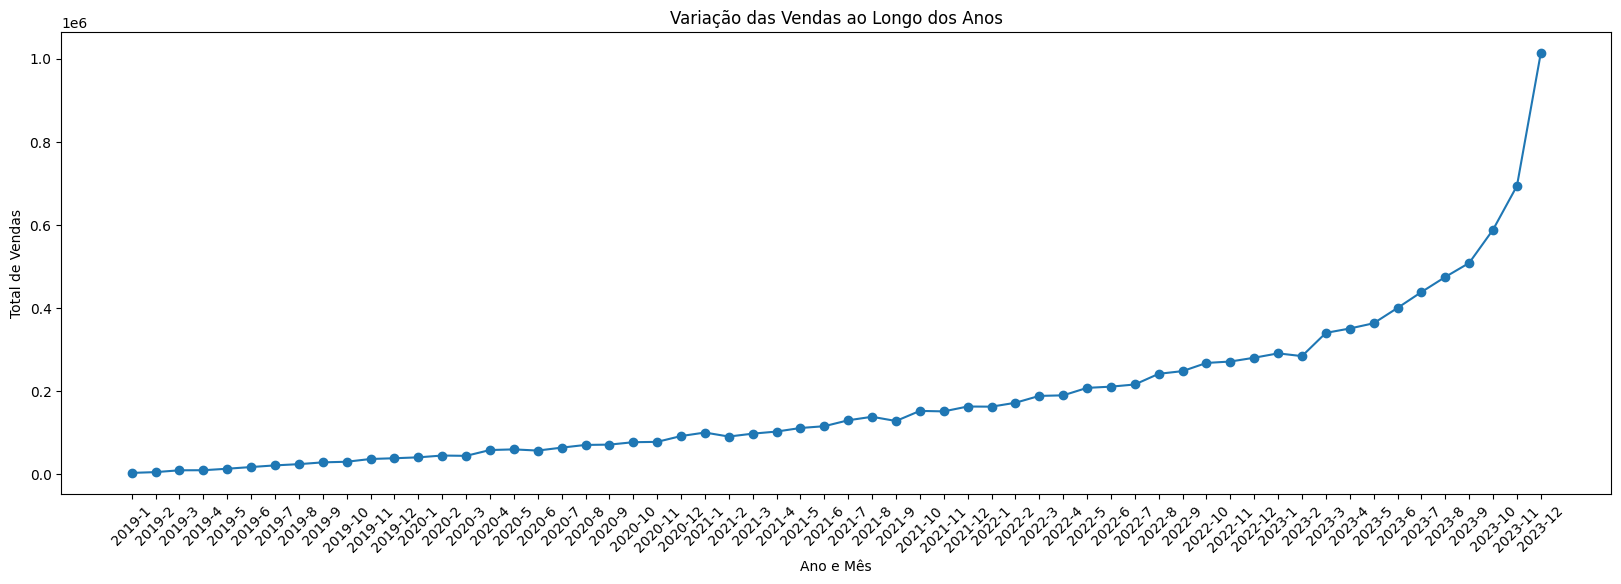

In [ ]:

# Consulta para obter informações sobre as vendas
sales_query = client.query(
    """
    SELECT
        EXTRACT(YEAR FROM o.created_at) AS ano,
        EXTRACT(MONTH FROM o.created_at) AS mes,
        SUM(oi.sale_price) AS total_vendas
    FROM
        `bigquery-public-data.thelook_ecommerce.orders` AS o
    JOIN
        `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    ON
        o.order_id = oi.order_id
    JOIN
        `bigquery-public-data.thelook_ecommerce.inventory_items` AS ii
    ON
        oi.inventory_item_id = ii.id
    GROUP BY
        ano, mes
    ORDER BY
        ano, mes
    """
)

# Executa a consulta e converte os resultados para um DataFrame do Pandas
sales_results = sales_query.result()
sales_df = pd.DataFrame(sales_results.to_dataframe())

# Cria um gráfico para visualizar as vendas ao longo do tempo
plt.figure(figsize=(20, 6))
plt.plot(sales_df['ano'].astype(str) + '-' + sales_df['mes'].astype(str), sales_df['total_vendas'], marker='o')
plt.title('Variação das Vendas ao Longo dos Anos')
plt.xlabel('Ano e Mês')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=45)
plt.show()

In [49]:
# Consulta para obter informações detalhadas sobre as vendas por produto
detailed_sales_query = client.query(
    """
    SELECT
        p.name AS product_name,
        p.category AS product_category,
        p.department AS product_department,
        EXTRACT(YEAR FROM o.created_at) AS ano,
        EXTRACT(MONTH FROM o.created_at) AS mes,
        COUNT(oi.product_id) AS total_units_sold,
        SUM(oi.sale_price) AS total_revenue
    FROM
        `bigquery-public-data.thelook_ecommerce.products` AS p
    JOIN
        `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    ON
        p.id = oi.product_id
    JOIN
        `bigquery-public-data.thelook_ecommerce.orders` AS o
    ON
        oi.order_id = o.order_id
    GROUP BY
        product_name, product_category, product_department, ano, mes
    ORDER BY
        total_units_sold DESC
    """
)

# Executa a consulta e converte os resultados para um DataFrame do Pandas
detailed_sales_results = detailed_sales_query.result()
detailed_sales_df = pd.DataFrame(detailed_sales_results.to_dataframe())

# Agrupa por produto, categoria e departamento, somando as unidades vendidas
top_products = detailed_sales_df.groupby(['product_name', 'product_category', 'product_department'])['total_units_sold'].sum().reset_index()

# Ordena pela quantidade de unidades vendidas em ordem decrescente e pega os top 15
top_products = top_products.sort_values(by='total_units_sold', ascending=False).head(15)

print("Top 15 produtos mais vendidos, suas categorias e departamentos:")
print(top_products[['product_name', 'product_category', 'product_department', 'total_units_sold']])


Top 15 produtos mais vendidos, suas categorias e departamentos:
                                            product_name product_category  \
27810  Wrangler Men's Premium Performance Cowboy Cut ...            Jeans   
27809  Wrangler Men's Original Cowboy Cut Relaxed Fit...            Jeans   
26793      Volcom Men's Vorta Slim Straight Leg Fit Jean            Jeans   
27824        Wrangler Men's Rugged Wear Classic Fit Jean            Jeans   
487    7 For All Mankind Men's Standard Classic Strai...            Jeans   
16206  Lucky Brand Mens Men's 361 Vintage Straight De...            Jeans   
27846                 Wrangler Men's Wrancher Dress Jean            Jeans   
25672            True Religion Men's Ricky Straight Jean            Jeans   
18821                     Nike Classic Fleece Hooded Top           Active   
20974                                   Puma Men's Socks            Socks   
11767                     Hanes Men's 4 Pack Boxer Brief        Underwear   
26732       

A análise dos Top 15 produtos mais vendidos oferece uma visão abrangente do comportamento do consumidor e das tendências de mercado. A categoria predominante entre esses produtos é "Jeans". Dentro do departamento "Men", observamos que os consumidores têm uma clara inclinação para produtos masculinos, indicando uma oportunidade estratégica para aprimorar ainda mais o portfólio nessa área.

Dentre os produtos mais destacados, os jeans Wrangler se destacam como líderes, apontando para uma forte preferência por essa marca específica. Essa informação é crucial para direcionar esforços de marketing e estratégias de estoque, permitindo à empresa capitalizar ainda mais sobre a popularidade dessa linha de produtos.

Esses insights não apenas beneficiam as estratégias de vendas e promoção, mas também têm implicações importantes no desenvolvimento futuro de produtos. Ao compreender as preferências dos consumidores e o desempenho de produtos específicos, a empresa pode direcionar seus recursos para áreas de maior sucesso, garantindo a satisfação do cliente e otimizando as operações.